In [ ]:
# Run these in separate cells, one at a time:
!pip install torch torchvision torchaudio
!pip install transformers
!pip install datasets
!pip install peft
!pip install evaluate
!pip install pandas numpy matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset as HFDataset, load_dataset
from peft import LoraConfig, get_peft_model, TaskType
import evaluate

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"Using device: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully!
Using device: Tesla T4


In [ ]:
# Load the emotion dataset from Hugging Face
emotion_dataset = load_dataset("dair-ai/emotion")

print("Emotion Dataset Info:")
print(emotion_dataset)

# Check the label mapping
label_names = emotion_dataset['train'].features['label'].names
print(f"\nEmotion labels: {label_names}")

# Convert to pandas for easier exploration
train_emotions = pd.DataFrame(emotion_dataset['train'])
print(f"\nEmotion dataset shape: {train_emotions.shape}")
print(f"Label distribution:\n{train_emotions['label'].value_counts()}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Emotion Dataset Info:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Emotion dataset shape: (16000, 2)
Label distribution:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


In [ ]:
# Prepare the emotion dataset
def prepare_emotion_data():
    # Convert HuggingFace dataset to format suitable for training
    train_data = []
    val_data = []
    test_data = []

    for split, data_list in [('train', train_data), ('validation', val_data), ('test', test_data)]:
        for example in emotion_dataset[split]:
            data_list.append({
                'text': example['text'],
                'label': example['label']
            })

    return train_data, val_data, test_data

train_data, val_data, test_data = prepare_emotion_data()

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

# Create label to id mapping
label2id = {label: i for i, label in enumerate(label_names)}
id2label = {i: label for label, i in label2id.items()}

print(f"\nLabel mapping: {label2id}")

Training samples: 16000
Validation samples: 2000
Test samples: 2000

Label mapping: {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}


In [ ]:
# Initialize RoBERTa tokenizer and model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load the model for sequence classification
num_labels = len(label_names)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

print("Model and tokenizer loaded successfully!")
print(f"Model parameters: {model.num_parameters():,}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!
Model parameters: 124,650,246


In [ ]:
# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification
    inference_mode=False,
    r=16,  # Rank of adaptation
    lora_alpha=32,  # LoRA scaling parameter
    lora_dropout=0.1,  # LoRA dropout
    target_modules=["query", "value"]  # Target attention modules
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

trainable params: 1,185,030 || all params: 125,835,276 || trainable%: 0.9417


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = str(item['text'])
        label = item['label']

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
max_length = 128  # Adjust based on your text length
train_dataset = EmotionDataset(train_data, tokenizer, max_length)
val_dataset = EmotionDataset(val_data, tokenizer, max_length)
test_dataset = EmotionDataset(test_data, tokenizer, max_length)

print(f"Datasets created successfully!")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Datasets created successfully!
Train dataset size: 16000
Validation dataset size: 2000


In [ ]:
# Cell 2: Check the original training data distribution
from datasets import load_dataset

# Load the emotion dataset to check original distribution
emotion_dataset = load_dataset("dair-ai/emotion")
train_emotions = emotion_dataset['train']

# Check label distribution
import pandas as pd
train_df = pd.DataFrame(train_emotions)
label_names = emotion_dataset['train'].features['label'].names

print(" ORIGINAL TRAINING DATA ANALYSIS")
print("="*50)

# Show distribution
label_counts = train_df['label'].value_counts().sort_index()
print("Original dataset emotion distribution:")
for label_id, count in label_counts.items():
    emotion_name = label_names[label_id]
    percentage = (count / len(train_df)) * 100
    print(f"  {emotion_name}: {count} samples ({percentage:.1f}%)")

print(f"\nTotal training samples: {len(train_df)}")



 ORIGINAL TRAINING DATA ANALYSIS
Original dataset emotion distribution:
  sadness: 4666 samples (29.2%)
  joy: 5362 samples (33.5%)
  love: 1304 samples (8.2%)
  anger: 2159 samples (13.5%)
  fear: 1937 samples (12.1%)
  surprise: 572 samples (3.6%)

Total training samples: 16000


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Step 2: Recreate the data collator (this was missing!)
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Step 3: Recreate compute_metrics function (in case it's missing)
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    return {
        'accuracy': accuracy['accuracy']
    }

# Step 4: Updated training arguments
from transformers import TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    report_to=[],  # Explicitly disable all reporting including wandb
    gradient_checkpointing=True,
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    run_name="emotion-classification-lora",
)

callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
print("Training arguments configured!")

Training arguments configured!


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,  # Keep this as tokenizer (processing_class might not work in older versions)
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("✅ All components created successfully!")
print("✅ Wandb disabled")
print("✅ Data collator created")
print("✅ Trainer initialized")


/tmp/ipython-input-9-3951047799.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ All components created successfully!
✅ Wandb disabled
✅ Data collator created
✅ Trainer initialized


In [ ]:
print("\nStarting training...")
trainer.train()

print(" Training completed!")


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.571600,1.578000,0.352000
1000,1.581200,1.571662,0.352000
1500,1.568800,1.562731,0.378000
2000,1.566300,1.555232,0.360000
2500,1.543100,1.548927,0.417000
3000,1.530900,1.543579,0.408500
3500,1.530200,1.533339,0.395000
4000,1.516500,1.532468,0.515000
4500,1.524500,1.521102,0.450000
5000,1.537800,1.513828,0.496000


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

 Training completed!


In [ ]:
print("Evaluating on test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")


Evaluating on test set...


Test Results: {'eval_loss': 1.506807565689087, 'eval_accuracy': 0.5155, 'eval_runtime': 13.6312, 'eval_samples_per_second': 146.722, 'eval_steps_per_second': 9.17, 'epoch': 5.5}


In [ ]:


# Step 2: Function for single text inference
def predict_emotion(text, return_probabilities=False):
    """
    Predict emotion for a single text input

    Args:
        text (str): Input text to classify
        return_probabilities (bool): Whether to return probability scores

    Returns:
        dict: Prediction results
    """
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # Move to same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get predicted class
    predicted_class_id = predictions.argmax().item()
    predicted_emotion = id2label[predicted_class_id]
    confidence = predictions[0][predicted_class_id].item()

    result = {
        'text': text,
        'predicted_emotion': predicted_emotion,
        'confidence': confidence
    }

    if return_probabilities:
        # Get all emotion probabilities
        all_probs = {id2label[i]: prob.item() for i, prob in enumerate(predictions[0])}
        result['all_probabilities'] = all_probs

    return result

In [ ]:
sample_texts = [
    "I am so happy today! Everything is going great!",
    "This is really frustrating and annoying.",
    "I feel so sad and lonely right now.",
    "I'm terrified of what might happen next.",
    "What a wonderful surprise! I didn't expect this.",
    "I love spending time with my family and friends."
]

print("\n" + "="*60)
print("EMOTION PREDICTIONS FOR SAMPLE TEXTS")
print("="*60)

for text in sample_texts:
    result = predict_emotion(text, return_probabilities=True)
    print(f"\nText: {result['text']}")
    print(f"Predicted Emotion: {result['predicted_emotion'].upper()}")
    print(f"Confidence: {result['confidence']:.3f}")
    print("All Probabilities:")
    for emotion, prob in sorted(result['all_probabilities'].items(),
                               key=lambda x: x[1], reverse=True):
        print(f"  {emotion}: {prob:.3f}")
    print("-" * 40)


EMOTION PREDICTIONS FOR SAMPLE TEXTS

Text: I am so happy today! Everything is going great!
Predicted Emotion: JOY
Confidence: 0.406
All Probabilities:
  joy: 0.406
  sadness: 0.249
  anger: 0.117
  fear: 0.114
  love: 0.076
  surprise: 0.037
----------------------------------------

Text: This is really frustrating and annoying.
Predicted Emotion: SADNESS
Confidence: 0.363
All Probabilities:
  sadness: 0.363
  joy: 0.237
  anger: 0.158
  fear: 0.127
  love: 0.077
  surprise: 0.039
----------------------------------------

Text: I feel so sad and lonely right now.
Predicted Emotion: SADNESS
Confidence: 0.418
All Probabilities:
  sadness: 0.418
  joy: 0.190
  anger: 0.148
  fear: 0.132
  love: 0.076
  surprise: 0.036
----------------------------------------

Text: I'm terrified of what might happen next.
Predicted Emotion: SADNESS
Confidence: 0.332
All Probabilities:
  sadness: 0.332
  joy: 0.247
  fear: 0.158
  anger: 0.144
  love: 0.079
  surprise: 0.040
-----------------------------

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
def save_complete_model():
    """
    Save the trained model, tokenizer, and training information
    """
    save_directory = "./emotion_classification_lora_model"

    # Create directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)

    print(" Saving model components...")

    # 1. Save the PEFT model (LoRA adapters)
    model.save_pretrained(save_directory)
    print(f" PEFT model saved to {save_directory}")

    # 2. Save the tokenizer
    tokenizer.save_pretrained(save_directory)
    print(f" Tokenizer saved to {save_directory}")

    # 3. Save label mappings and model info
    model_info = {
        "base_model": model_name,
        "num_labels": num_labels,
        "label2id": label2id,
        "id2label": {str(k): v for k, v in id2label.items()},  # Convert int keys to strings
        "label_names": label_names,
        "lora_config": {
            "r": lora_config.r,
            "lora_alpha": lora_config.lora_alpha,
            "lora_dropout": lora_config.lora_dropout,
            "target_modules": list(lora_config.target_modules) if hasattr(lora_config.target_modules, '__iter__') else lora_config.target_modules
        }
    }

    with open(f"{save_directory}/model_info.json", "w") as f:
        json.dump(model_info, f, indent=2)
    print(f" Model info saved to {save_directory}/model_info.json")

    print(f"\n Complete model saved successfully to: {save_directory}")
    return save_directory

# Save the model
model_save_path = save_complete_model()

 Saving model components...
 PEFT model saved to ./emotion_classification_lora_model
 Tokenizer saved to ./emotion_classification_lora_model
 Model info saved to ./emotion_classification_lora_model/model_info.json

 Complete model saved successfully to: ./emotion_classification_lora_model


In [ ]:
import shutil
import os
from google.colab import files

def create_and_download_model_zip():
    """
    Create a ZIP file of the model and download it
    """
    model_dir = "./emotion_classification_lora_model"
    zip_filename = "emotion_classification_model"

    print(" Creating ZIP file...")

    # Create ZIP file
    shutil.make_archive(zip_filename, 'zip', model_dir)

    zip_path = f"{zip_filename}.zip"

    # Check file size
    file_size = os.path.getsize(zip_path) / (1024 * 1024)  # Size in MB
    print(f" ZIP file created: {zip_path}")
    print(f" File size: {file_size:.2f} MB")

    # Download the file
    print("⬇ Starting download...")
    files.download(zip_path)

    print(" Download complete!")
    print(f" The file 'emotion_classification_model.zip' should now be in your Downloads folder")

    return zip_path

# Run this to download your model
create_and_download_model_zip()

 Creating ZIP file...
 ZIP file created: emotion_classification_model.zip
 File size: 4.29 MB
⬇ Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Download complete!
 The file 'emotion_classification_model.zip' should now be in your Downloads folder


'emotion_classification_model.zip'

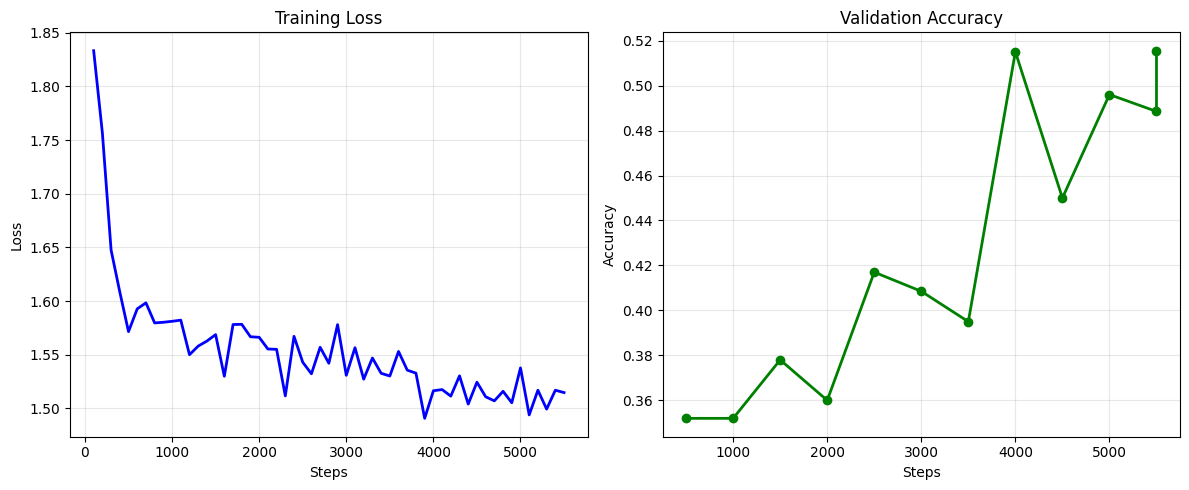

 Final Training Loss: 1.5148
 Final Validation Accuracy: 0.5155
 Best Validation Accuracy: 0.5155


In [ ]:
# Simple Training Metrics Visualization

import matplotlib.pyplot as plt
import pandas as pd

# Extract logs
logs = trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in logs if 'eval_loss' in log]

# Create simple plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training Loss
if train_logs:
    steps = [log['step'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    ax1.plot(steps, losses, 'b-', linewidth=2)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

# Validation Accuracy
if eval_logs:
    eval_steps = [log['step'] for log in eval_logs]
    if 'eval_accuracy' in eval_logs[0]:
        accuracies = [log['eval_accuracy'] for log in eval_logs]
        ax2.plot(eval_steps, accuracies, 'g-', linewidth=2, marker='o')
        ax2.set_title('Validation Accuracy')
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick stats
if train_logs and eval_logs:
    print(f" Final Training Loss: {train_logs[-1]['loss']:.4f}")
    if 'eval_accuracy' in eval_logs[-1]:
        print(f" Final Validation Accuracy: {eval_logs[-1]['eval_accuracy']:.4f}")
        print(f" Best Validation Accuracy: {max(log['eval_accuracy'] for log in eval_logs):.4f}")

# Inference on the IMDB movie dataset

In [ ]:
# Import required libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
import json
from tqdm import tqdm

print("Libraries imported successfully!")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully!
Using device: GPU


In [ ]:
# Load model configuration
with open("./emotion_classification_lora_model/model_info.json", "r") as f:
    model_info = json.load(f)

# Get label mappings
id2label = {int(k): v for k, v in model_info["id2label"].items()}
label2id = model_info["label2id"]

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./emotion_classification_lora_model")

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=6,
    id2label=id2label,
    label2id=label2id
)

# Load your fine-tuned LoRA model
model = PeftModel.from_pretrained(base_model, "./emotion_classification_lora_model")
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("✅ Model loaded successfully!")
print(f"Available emotions: {list(id2label.values())}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!
Available emotions: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [ ]:

# Cell 3: Load your movies dataset
print("Loading movies dataset...")

# Load the CSV file (make sure you've uploaded movies_cleaned.csv to Colab)
movies_df = pd.read_csv('movies_cleaned.csv')

print(f"✅ Loaded {len(movies_df)} movies")
print(f"Columns: {list(movies_df.columns)}")

# Clean the Overview column
movies_df['Overview'] = movies_df['Overview'].fillna("No description available")
movies_df['Overview'] = movies_df['Overview'].astype(str)

# Show first few examples
print("\nFirst 3 movie overviews:")
for i in range(3):
    title = movies_df.iloc[i]['Series_Title']
    overview = movies_df.iloc[i]['Overview'][:100] + "..."
    print(f"{i+1}. {title}: {overview}")

Loading movies dataset...
✅ Loaded 1000 movies
Columns: ['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'tagged_description']

First 3 movie overviews:
1. The Shawshank Redemption: Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts ...
2. The Godfather: An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his relu...
3. The Dark Knight: When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accep...


In [ ]:
# Cell 4: Simple function to predict emotion
def predict_emotion(text):
    """Predict emotion for a single text"""

    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = probabilities.argmax().item()
        confidence = probabilities.max().item()

    # Return emotion and confidence
    emotion = id2label[predicted_class]
    return emotion, confidence

# Test with one movie
test_overview = movies_df.iloc[0]['Overview']
test_emotion, test_confidence = predict_emotion(test_overview)
print(f"Test prediction:")
print(f"Overview: {test_overview[:100]}...")
print(f"Predicted emotion: {test_emotion}")
print(f"Confidence: {test_confidence:.3f}")

Test prediction:
Overview: Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts ...
Predicted emotion: sadness
Confidence: 0.328


In [ ]:
# Cell 5: Predict emotions for all movies
print("🔮 Predicting emotions for all movies...")

# Lists to store results
emotions = []
confidences = []

# Process each movie
for i, overview in tqdm(enumerate(movies_df['Overview']), total=len(movies_df)):
    emotion, confidence = predict_emotion(overview)
    emotions.append(emotion)
    confidences.append(confidence)

# Add new columns to dataframe
movies_df['emotion'] = emotions
movies_df['emotion_confidence'] = confidences

print("✅ Emotion prediction completed!")
print(f"Added 'emotion' column to your dataframe")

🔮 Predicting emotions for all movies...


100%|██████████| 1000/1000 [00:27<00:00, 36.95it/s]

✅ Emotion prediction completed!
Added 'emotion' column to your dataframe


In [ ]:
# Cell 6: View results and save
print("🎯 RESULTS SUMMARY")
print("="*50)

# Show emotion distribution
emotion_counts = movies_df['emotion'].value_counts()
print("Emotion Distribution:")
for emotion, count in emotion_counts.items():
    percentage = (count / len(movies_df)) * 100
    print(f"  {emotion}: {count} movies ({percentage:.1f}%)")

print(f"\nAverage confidence: {movies_df['emotion_confidence'].mean():.3f}")

# Show sample results
print("\n🎬 SAMPLE RESULTS:")
print("="*50)

# Show 5 random examples
sample_movies = movies_df.sample(5)
for _, movie in sample_movies.iterrows():
    title = movie['Series_Title']
    emotion = movie['emotion']
    confidence = movie['emotion_confidence']
    overview = movie['Overview'][:80] + "..."

    print(f"\nMovie: {title}")
    print(f"Emotion: {emotion.upper()} (Confidence: {confidence:.3f})")
    print(f"Overview: {overview}")
    print("-" * 40)

# Save the results
movies_df.to_csv('movies_with_emotions.csv', index=False)
print(f"\n💾 Results saved to 'movies_with_emotions.csv'")
print(f"Your dataframe now has {len(movies_df.columns)} columns including 'emotion'!")

🎯 RESULTS SUMMARY
Emotion Distribution:
  sadness: 905 movies (90.5%)
  joy: 95 movies (9.5%)

Average confidence: 0.319

🎬 SAMPLE RESULTS:

Movie: Trois couleurs: Bleu
Emotion: SADNESS (Confidence: 0.354)
Overview: A woman struggles to find a way to live her life after the death of her husband ...
----------------------------------------

Movie: Captain America: The Winter Soldier
Emotion: SADNESS (Confidence: 0.317)
Overview: As Steve Rogers struggles to embrace his role in the modern world, he teams up w...
----------------------------------------

Movie: Wreck-It Ralph
Emotion: SADNESS (Confidence: 0.329)
Overview: A video game villain wants to be a hero and sets out to fulfill his dream, but h...
----------------------------------------

Movie: The Sandlot
Emotion: SADNESS (Confidence: 0.290)
Overview: In the summer of 1962, a new kid in town is taken under the wing of a young base...
----------------------------------------

Movie: Gandhi
Emotion: SADNESS (Confidence: 0.324)
Over

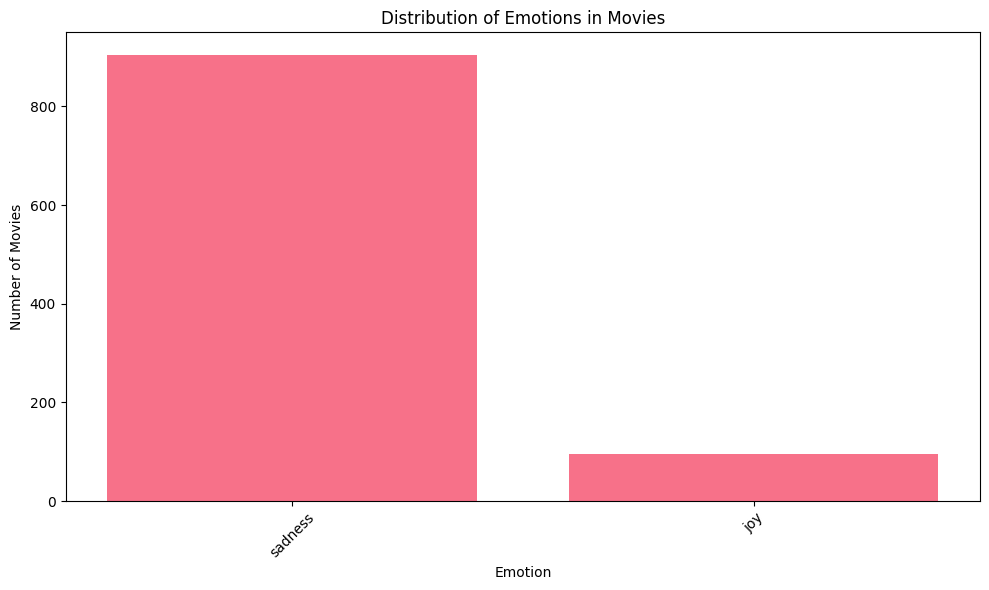

📊 Visualization complete!


In [ ]:
# Cell 7: Simple visualization (optional)
import matplotlib.pyplot as plt

# Create a simple bar chart of emotion distribution
plt.figure(figsize=(10, 6))
emotion_counts = movies_df['emotion'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribution of Emotions in Movies')
plt.xlabel('Emotion')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("📊 Visualization complete!")

In [ ]:
movies=pd.read_csv('movies_with_emotions.csv')

In [ ]:
movies

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,tagged_description,emotion,emotion_confidence
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469",0 Two imprisoned men bond over a number of yea...,sadness,0.328030
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411",1 An organized crime dynasty's aging patriarch...,sadness,0.316358
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444",2 When the menace known as the Joker wreaks ha...,sadness,0.350182
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000",3 The early life and career of Vito Corleone i...,joy,0.299055
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000",4 A jury holdout attempts to prevent a miscarr...,sadness,0.328986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://m.media-amazon.com/images/M/MV5BNGEwMT...,Breakfast at Tiffany's,1961,A,115 min,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN,995 A young New York socialite becomes interes...,sadness,0.319391
996,https://m.media-amazon.com/images/M/MV5BODk3Yj...,Giant,1956,G,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN,996 Sprawling epic covering the life of a Texa...,sadness,0.308605
997,https://m.media-amazon.com/images/M/MV5BM2U3Yz...,From Here to Eternity,1953,Passed,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,"30,500,000","997 In Hawaii in 1941, a private is cruelly pu...",sadness,0.316036
998,https://m.media-amazon.com/images/M/MV5BZTBmMj...,Lifeboat,1944,NaN,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN,998 Several survivors of a torpedoed merchant ...,sadness,0.324485
